# 6.6 Sourcing & Analyzing Time-Series Data

### This script contains the following:

#### 1. Importing your libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity
#### 5. Stationarizing the Federal Reserve Economic Data

### 1. Importing your libraries and data

In [203]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") 

plt.style.use('fivethirtyeight') 

In [204]:
# Configure API key 

quandl.ApiConfig.api_key = '2-F2f5AMcwimAxihZEhU'

In [205]:
# Importing the Federal Reserve Economic Data "Natural Rate of Unemployment" variable.

data = quandl.get('FRED/PAYEMS')

All Employees: Total Nonfarm, commonly known as Total Nonfarm Payroll, is a measure of the number of U.S. workers in the economy that excludes proprietors, private household employees, unpaid volunteers, farm employees, and the unincorporated self-employed. This measure accounts for approximately 80 percent of the workers who contribute to Gross Domestic Product (GDP).

In [206]:
data.head(5)

,Value
Date,
1939-01-01,29923.0
1939-02-01,30100.0
1939-03-01,30280.0
1939-04-01,30094.0
1939-05-01,30299.0


In [207]:
data.shape

(997, 1)

In [208]:
data.columns

Index(['Value'], dtype='object')

In [209]:
type(data)

pandas.core.frame.DataFrame

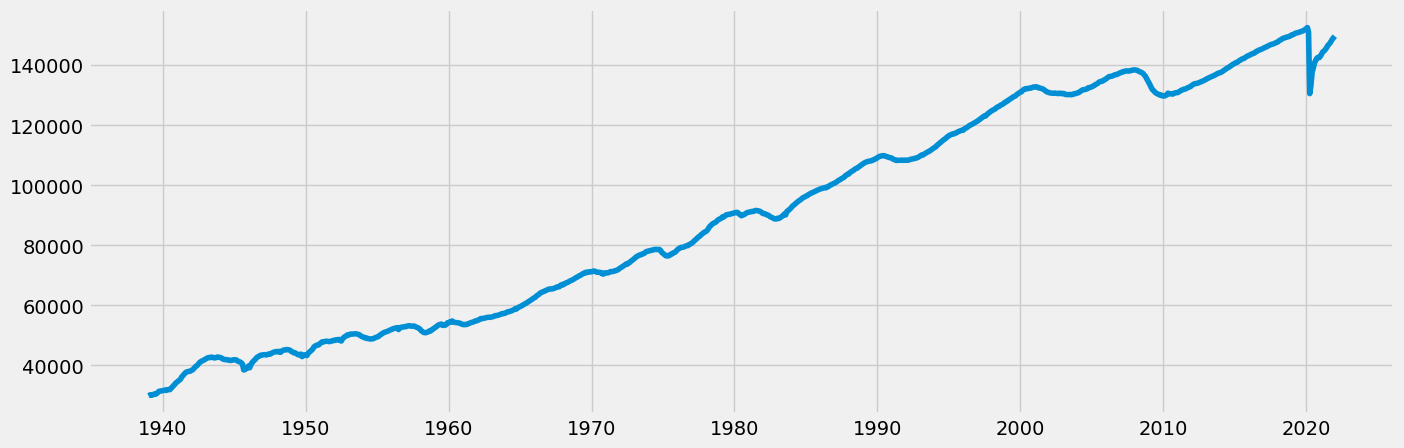

In [210]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) 

plt.plot(data)

### 2. Subsetting, wrangling, and cleaning time-series data

In [211]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [212]:
data_2.head()

,Date,Value
0,1939-01-01,29923.0
1,1939-02-01,30100.0
2,1939-03-01,30280.0
3,1939-04-01,30094.0
4,1939-05-01,30299.0


In [213]:
data_sub = data_2.loc[(data_2['Date'] >= '1980-01-01') & (data_2['Date'] < '2020-06-01')]

In [214]:
data_sub.shape

(485, 2)

In [215]:
data_sub.head()

,Date,Value
492,1980-01-01,90800.0
493,1980-02-01,90883.0
494,1980-03-01,90994.0
495,1980-04-01,90849.0
496,1980-05-01,90420.0


In [216]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
1980-01-01,90800.0
1980-02-01,90883.0
1980-03-01,90994.0
1980-04-01,90849.0
1980-05-01,90420.0


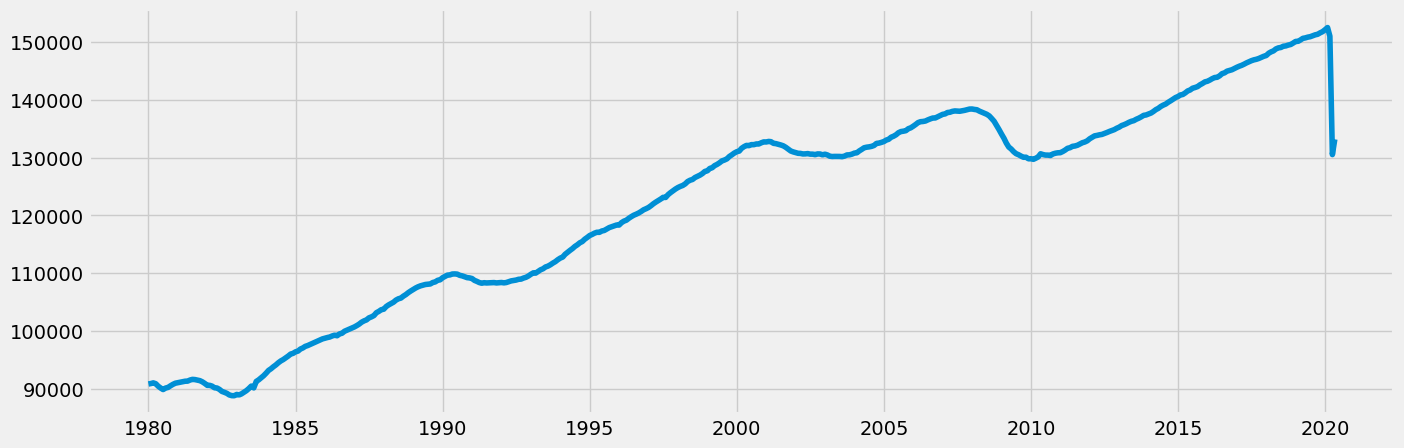

In [217]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [218]:
# Check for missing values (you shouldn't have any)

data_sub.isnull().sum() 

Value    0
dtype: int64

In [219]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()

3

In [220]:
# Drop duplicates

data_sub = data_sub.drop_duplicates()

### 3. Time-series analysis: decomposition

In [221]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive', period=12)


In [222]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

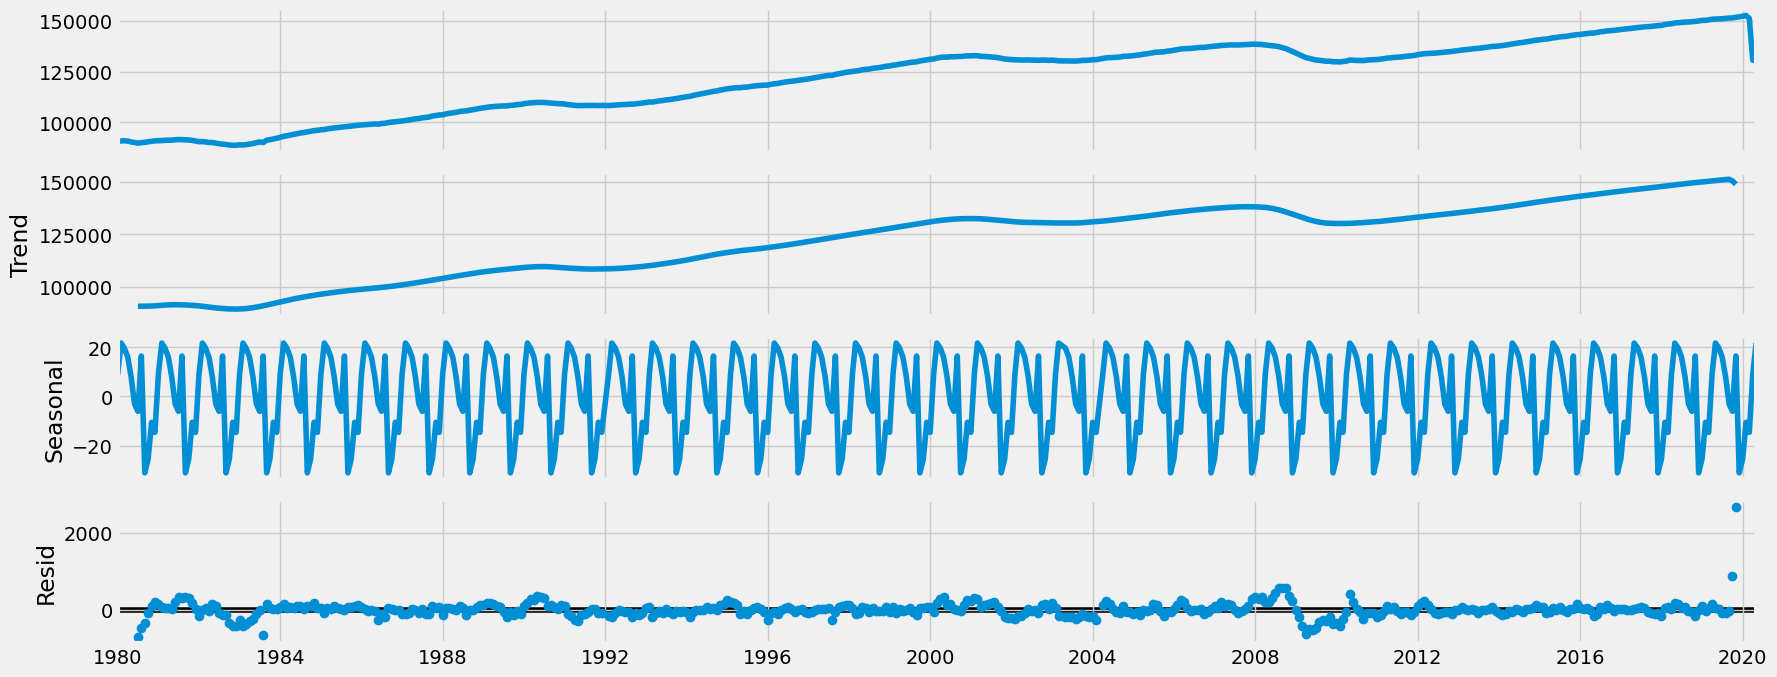

In [223]:
# Plot the separate components

decomposition.plot()
plt.show()

**Observations**: 
- From the grafic plot it is seen that there is a trend of increasing employment level over the years, whcih means that unemploymnet rates are dicreasing. 
- We can notice that employment rate decreased after the economic crisis in 2008 and we can notice significant decrease in 2019 which can be explained by the COVID-19 pandemic 

### 4. Testing for stationarity

In [224]:
from statsmodels.tsa.stattools import adfuller

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -1.845118
p-value                          0.358303
Number of Lags Used              4.000000
Number of Observations Used    477.000000
Critical Value (1%)             -3.444134
Critical Value (5%)             -2.867618
Critical Value (10%)            -2.570008
dtype: float64


- The test statistic is less than the critical values at 1%, 5%, and 10% levels.
- The p-value is greater than 0.05.
Based on these results, we do not have enough evidence to reject the null hypothesis of a unit root. This suggests that the data is Non-stationary.

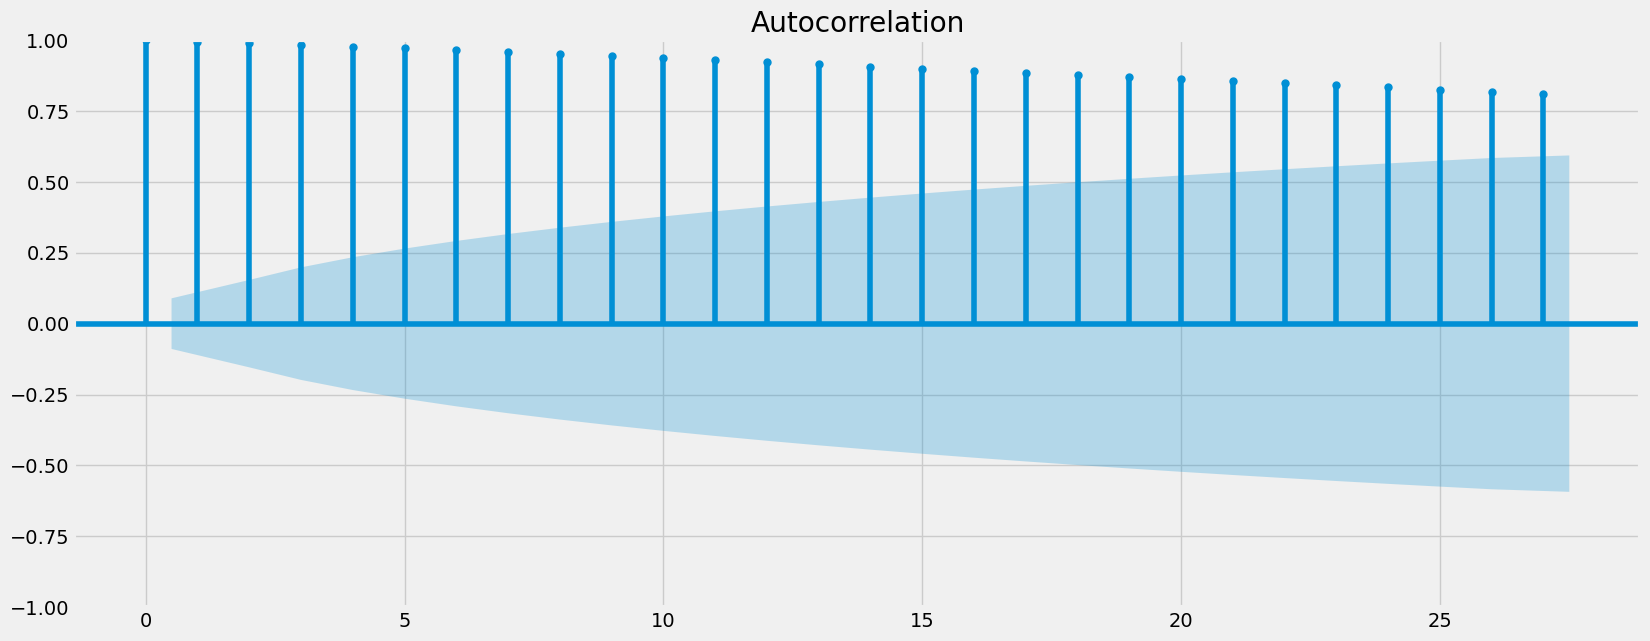

In [225]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

plot_acf(data_sub)
plt.show()

There are many lags above the confidence interval edge, which means there are many lags significantly correlated with each other 

### 5. Stationarizing the Federal Reserve Economic Data

In [226]:
data_diff = data_sub - data_sub.shift(1) 

In [227]:
data_diff.dropna(inplace = True)

In [228]:
data_diff.head()

,Value
datetime,
1980-02-01,83.0
1980-03-01,111.0
1980-04-01,-145.0
1980-05-01,-429.0
1980-06-01,-319.0


In [229]:
data_diff.columns

Index(['Value'], dtype='object')

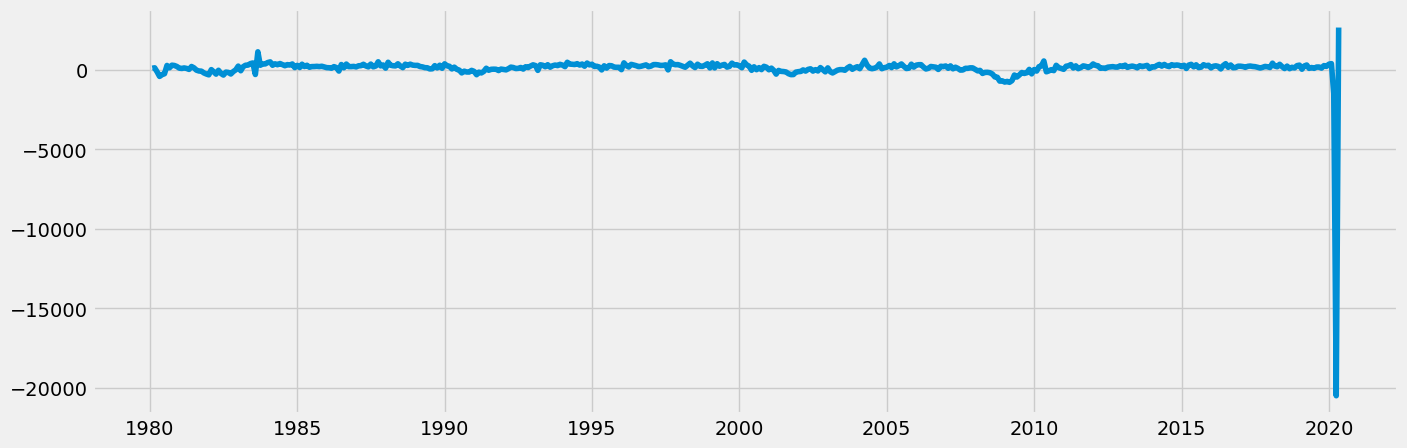

In [230]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [233]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -1.908543
p-value                          0.328053
Number of Lags Used              3.000000
Number of Observations Used    477.000000
Critical Value (1%)             -3.444134
Critical Value (5%)             -2.867618
Critical Value (10%)            -2.570008
dtype: float64


still non-stationary

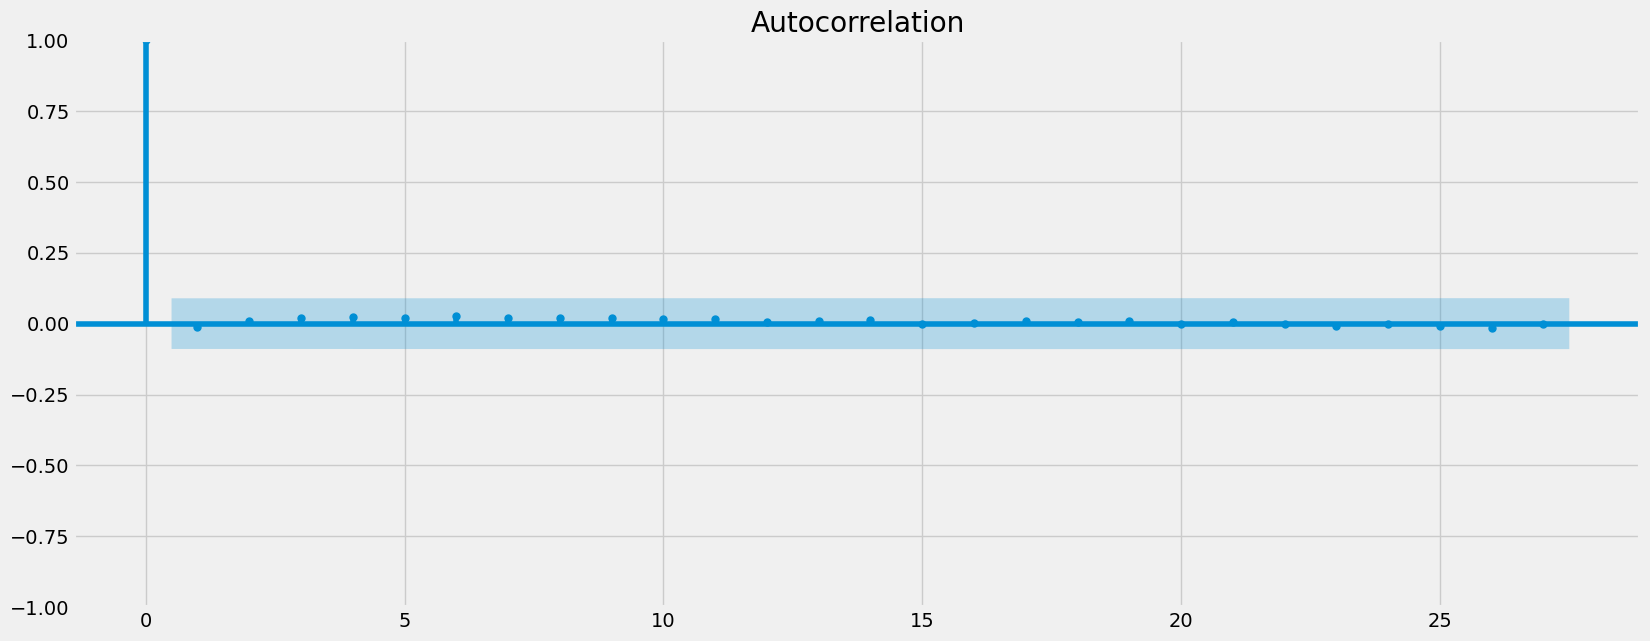

In [242]:
plot_acf(data_diff)
plt.show()

The autocorrelation plot has improved, it’s still not perfect. This approves the Dickey-Fuller test saying that the data is non-stationary. I will try to use moving average to make time series stationary. 

In [236]:
# Using Moving Average 
window_size = 12  # Choose an appropriate window size
rolling_mean = data_diff['Value'].rolling(window=window_size).mean()
data_stationary = data_diff['Value'] - rolling_mean
data_stationary.dropna(inplace=True)

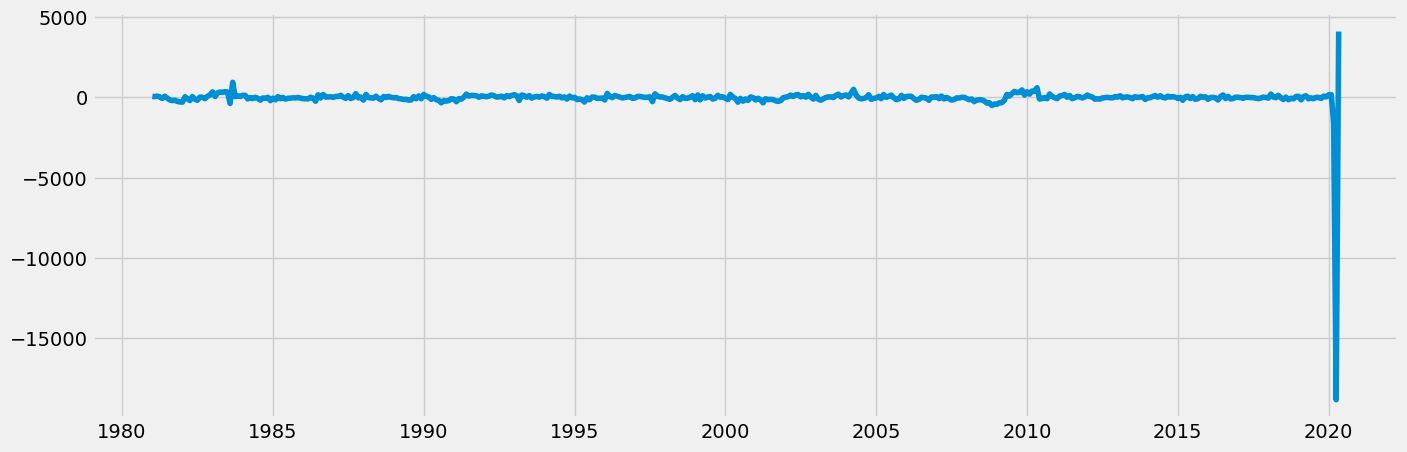

In [239]:
# Check out what the moving average did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_stationary)

In [240]:
dickey_fuller(data_stationary)


Dickey-Fuller Stationarity test:
Test Statistic                 -23.917739
p-value                          0.000000
Number of Lags Used              0.000000
Number of Observations Used    469.000000
Critical Value (1%)             -3.444370
Critical Value (5%)             -2.867722
Critical Value (10%)            -2.570063
dtype: float64


The highly negative test statistic and an extremely low p-value, shows strong evidence to reject the null hypothesis of non-stationarity. The time series appears to be stationary based on the Dickey-Fuller test. 

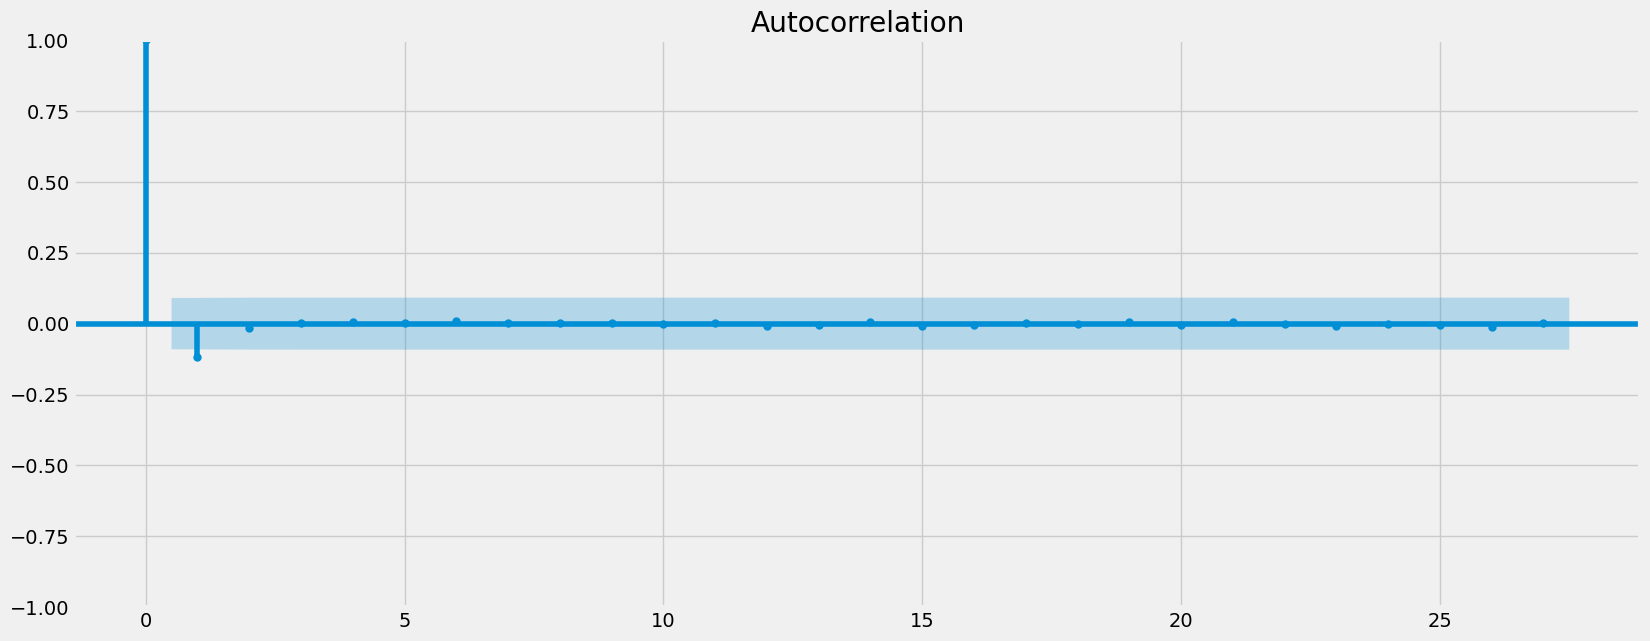

In [241]:
plot_acf(data_stationary)
plt.show()

The autocorrelation plot has slighty changed and now shows two lags. This means that, despite the Dickey-Fuller test saying that the data is stationary, that stationarity is weak.